In [15]:
import json
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
from IPython.display import display

In [16]:
#Simplement pr des figures un peu plus jolies
import seaborn as sns
sns.set()

In [17]:
with open('./port_activity_scenario.json') as f:
    data = json.load(f)
    
machines_uses = []
for machine in data["timeseries"]:
    for use in machine["uses"]:
        machine_use = {
            "machineId": machine["machineId"],
            "machineType": machine["machineType"],
            "energyType": machine["consumption"]["energyType"],
            "consumptionPerHour": machine["consumption"]["consumptionPerHour"]
        }
        for key, value in use.items():
            machine_use[key] = value
        machines_uses.append(machine_use)

In [18]:
df = pd.DataFrame.from_dict(machines_uses)
df

,machineId,machineType,energyType,consumptionPerHour,startTs,endTs,duration,operationId,operationName,supplychainId,cargoId
0,machine_00,convoyBelt,fuel,13,1570185023,1570190387,5364,op_0,drive,sc_5,cargo_9
1,machine_00,convoyBelt,fuel,13,1570191383,1570199113,7730,op_1,raise,sc_5,cargo_81
2,machine_00,convoyBelt,fuel,13,1570200389,1570216341,15952,op_2,filter,sc_5,cargo_5
3,machine_00,convoyBelt,fuel,13,1570222629,1570230173,7544,op_3,load,sc_8,cargo_44
4,machine_00,convoyBelt,fuel,13,1570236431,1570252530,16099,op_4,drive,sc_0,cargo_68
...,...,...,...,...,...,...,...,...,...,...,...
935,machine_49,convoyBelt,essence,13,1570391524,1570405583,14059,op_935,drop,sc_5,cargo_71
936,machine_49,convoyBelt,essence,13,1570406128,1570414781,8653,op_936,load,sc_6,cargo_93
937,machine_49,convoyBelt,essence,13,1570415674,1570430398,14724,op_937,filter,sc_5,cargo_84
938,machine_49,convoyBelt,essence,13,1570434830,1570438945,4115,op_938,drop,sc_1,cargo_63


consumptionPerHour
energyType datetime                               
diesel     2019-10-04 10:00:00                3232
           2019-10-04 11:00:00                7735
           2019-10-04 12:00:00               11408
           2019-10-04 13:00:00                9997
           2019-10-04 14:00:00                8712
...                                            ...
gazole     2019-10-07 09:00:00                6330
           2019-10-07 10:00:00                5472
           2019-10-07 11:00:00                3588
           2019-10-07 12:00:00                2728
           2019-10-07 13:00:00                1870

[313 rows x 1 columns]

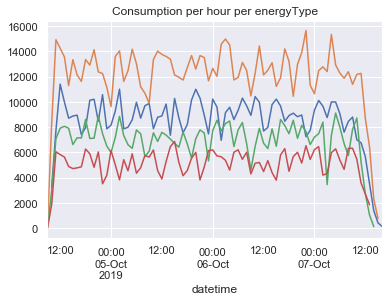

In [19]:
df["datetimes"] = df.apply(lambda row: pd.date_range(pd.to_datetime(row["startTs"], unit="s"), pd.to_datetime(row["endTs"], unit="s"), freq="1min").to_list(), axis=1)

tsdf = (df
    .set_index([elem for elem in list(df.columns) if elem != "datetimes"])["datetimes"]
    .apply(pd.Series)
    .stack()
    .reset_index()
    .drop('level_11', axis=1)
    .rename(columns={0:'datetime'})
)
tsdf['datetime'] = pd.to_datetime(tsdf['datetime'])
tsdf = tsdf.set_index('datetime')

df.drop(columns=["datetimes"])

energyTypesDf = tsdf.groupby(['energyType', pd.Grouper(freq='H')]).sum()
display(energyTypesDf[["consumptionPerHour"]])

energyTypes = list(set([row[0] for row in energyTypesDf.index]))
for energyType in energyTypes:
    energyTypesDf.loc[energyType]["consumptionPerHour"].plot(label=energyType, title="Consumption per hour per energyType")
plt.show()

- Supprimer premier et dernier pas de temps
- Afficher la légende
- Mettre un axe pr l'electricité, un autre pr les carburants fossil

,consumption
supplychainId,
sc_0,4526.896111
sc_1,4186.741111
sc_2,4114.173889
sc_3,4329.935278
sc_4,3059.938056
sc_5,4543.024167
sc_6,5187.965833
sc_7,3697.686111
sc_8,4829.393611


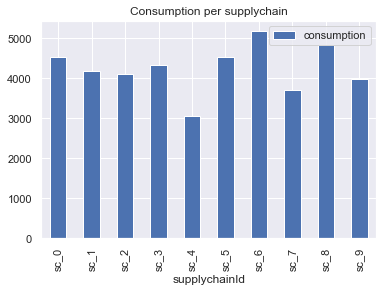

In [20]:
df["consumption"] = df.apply(lambda row: (row["duration"]/60./60)*row["consumptionPerHour"], axis=1)
consumptionDf = df.groupby(['supplychainId']).sum()[["consumption"]]
df.drop(columns=["consumption"])
display(consumptionDf)

consumptionDf.plot.bar(title="Consumption per supplychain")

- Mettre en série les types d'énergie:
    - stacker les fossil
- Présenter sur l'axe x les regroupements pr segment (solid bulk, cereal...) et type (pneus, blé...) de marchandise, puis supply-chain

,diesel,essence,fuel,gazole
supplychainId,,,,
sc_0,707.296389,752.958611,2201.101667,865.539444
sc_1,934.016667,465.650833,1858.767778,928.305833
sc_2,1677.635278,923.728333,973.605556,539.204722
sc_3,1020.906667,989.669167,1815.036667,504.322778
sc_4,827.506389,1014.790000,901.862500,315.779167
sc_5,1037.743333,1219.759444,1525.738333,759.783056
sc_6,1344.463333,812.132222,2072.738333,958.631944
sc_7,1148.409444,676.100833,1545.639444,327.536389
sc_8,1141.090278,1472.427222,1350.288056,865.588056


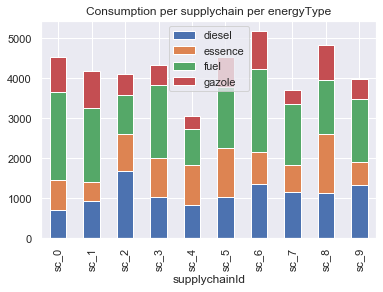

In [21]:
df["consumption"] = df.apply(lambda row: (row["duration"]/60./60)*row["consumptionPerHour"], axis=1)
consumptionDf = (
    df
    .groupby(['supplychainId', 'energyType'])
    .sum()
    [["consumption"]]
    .unstack('energyType')
)
df.drop(columns=["consumption"])
consumptionDf.columns = ['diesel', 'essence', 'fuel', 'gazole']
display(consumptionDf)

consumptionDf.plot.bar(stacked=True, title="Consumption per supplychain per energyType")


Boxplots of durations per machineType


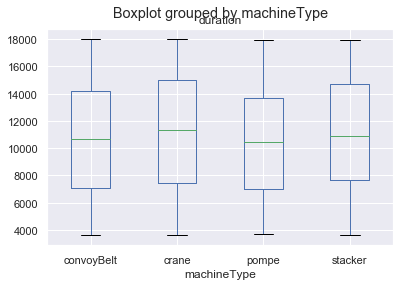

In [22]:
df.boxplot(column=["duration"], by="machineType")
print("Boxplots of durations per machineType")

In [23]:
machinesCount = (
    df
    .groupby(['machineType', 'machineId'])
    .count()
    [['startTs']]
    .rename(columns={'startTs': 'usesCount'})
)
display(machinesCount)

usesCount
machineType machineId            
convoyBelt  machine_00         19
            machine_07         18
            machine_08         20
            machine_12         20
            machine_14         17
            machine_16         18
            machine_17         17
            machine_18         19
            machine_31         18
            machine_41         20
            machine_42         18
            machine_43         19
            machine_46         20
            machine_48         18
            machine_49         19
crane       machine_03         18
            machine_05         18
            machine_09         17
            machine_13         18
            machine_15         18
            machine_19         17
            machine_20         18
            machine_24         21
            machine_28         22
            machine_32         19
            machine_34         17
            machine_38         21
            machine_40         19
            machine_44         19
            machine_47         20
pompe       machine_01         20
            machine_02         18
            machine_04         17
            machine_25         21
            machine_27         19
            machine_29         20
            machine_35         20
            machine_37         19
            machine_45         20
stacker     machine_06         20
            machine_10         18
            machine_11         18
            machine_21         21
            machine_22         20
            machine_23         19
            machine_26         15
            machine_30         17
            machine_33         18
            machine_36         19
            machine_39         19